In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from fbprophet import Prophet
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_absolute_error as mae

In [2]:
def preprocess_download(data, start_date_back, end_date_back):
    data = data.dropna(subset=['subregion1_name'])
    data = data[data.country_code == 'US']

    data = data[['date',
                 'subregion1_name',
                 'subregion2_name',
                 'new_confirmed',
                 'new_deceased',
                 'total_confirmed',
                 'total_deceased', 
                 'population', 
                 'population_male', 
                 'population_female',
                 'population_age_00_09', 
                 'population_age_10_19', 
                 'population_age_20_29',
                 'population_age_30_39',
                 'population_age_40_49',
                 'population_age_50_59',
                 'population_age_60_69', 
                 'population_age_70_79',
                 'population_age_80_and_older', 
                 'area', 
                 'mobility_workplaces', 
                 'noaa_station',
                 'noaa_distance', 
                 'average_temperature', 
                 'minimum_temperature',
                 'maximum_temperature', 
                 'rainfall', 
                 'dew_point', 
                 'relative_humidity']]
    
    data['days_back'] = [(datetime.now() - day).days for day in pd.to_datetime(data.date)]
    res = {}
    for state in data.subregion1_name.unique():
        print('State: ', state)
        tmp_state = data[data.subregion1_name == state]
        res[state] = {}
        for county in tmp_state.subregion2_name.unique():
            tmp_county = tmp_state[tmp_state.subregion2_name == county]
            tmp_county = tmp_county[tmp_county['days_back']<=start_date_back]
            tmp_county = tmp_county[tmp_county['days_back']>=end_date_back]
            if sum(tmp_county.new_confirmed.isna())==0:
                tmp_county.reset_index(inplace = True, drop = True)
                res[state][county] = {'Data':tmp_county}
        break
    
    return(res)

In [3]:
data = preprocess_download(pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/main.csv"), 90, 2)


/home/ec2-user/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2,3,6,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


State:  Alaska


In [4]:
tmp = data['Alaska']['Anchorage Municipality']['Data'][['date','new_confirmed']]
tmp

,date,new_confirmed
0,2020-07-29,52.0
1,2020-07-30,43.0
2,2020-07-31,83.0
3,2020-08-01,111.0
4,2020-08-02,109.0
...,...,...
84,2020-10-21,142.0
85,2020-10-22,65.0
86,2020-10-23,156.0
87,2020-10-24,185.0


In [5]:
y_train, y_test = temporal_train_test_split(tmp, test_size=1)

In [6]:
y_train

,date,new_confirmed
0,2020-07-29,52.0
1,2020-07-30,43.0
2,2020-07-31,83.0
3,2020-08-01,111.0
4,2020-08-02,109.0
...,...,...
83,2020-10-20,115.0
84,2020-10-21,142.0
85,2020-10-22,65.0
86,2020-10-23,156.0


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


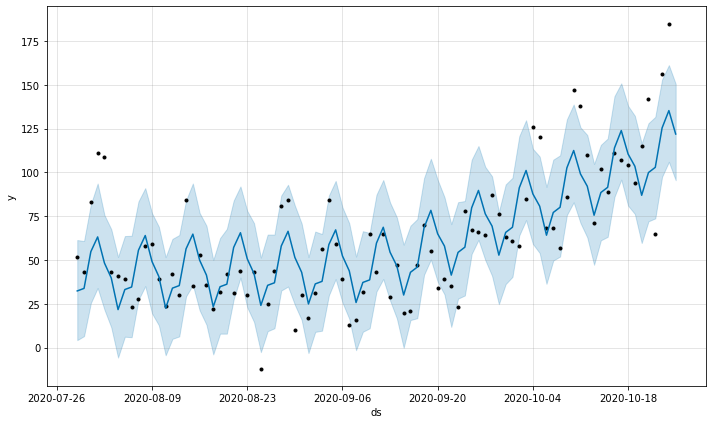

In [7]:
df = pd.DataFrame()
df['ds'] = pd.to_datetime(y_train.date)
df['y'] = y_train['new_confirmed'].values

prophet = Prophet()
prophet.fit(df)
future = prophet.make_future_dataframe(periods=len(y_test), freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)

In [8]:
fb_preds = forecast['yhat'].iloc[len(y_train):]
mae(y_test['new_confirmed'].values, fb_preds)

87.0519188637873

In [11]:
data['Alaska']['Aleutians West']['Data']

,date,subregion1_name,subregion2_name,new_confirmed,new_deceased,total_confirmed,total_deceased,population,population_male,population_female,...,mobility_workplaces,noaa_station,noaa_distance,average_temperature,minimum_temperature,maximum_temperature,rainfall,dew_point,relative_humidity,days_back
0,2020-07-29,Alaska,Aleutians West,0.0,0.0,87.0,0.0,5729.0,3795.0,1934.0,...,NaN,9.982250e+10,11.199648,10.518519,9.148148,12.537037,0.000000,9.000000,87.799486,90
1,2020-07-30,Alaska,Aleutians West,1.0,0.0,88.0,0.0,5729.0,3795.0,1934.0,...,NaN,9.982250e+10,11.199648,9.148148,7.722222,10.907407,0.084667,7.666667,92.045045,89
2,2020-07-31,Alaska,Aleutians West,1.0,0.0,89.0,0.0,5729.0,3795.0,1934.0,...,NaN,9.982250e+10,11.199648,9.574074,8.018519,11.518519,0.000000,8.666667,92.448764,88
3,2020-08-01,Alaska,Aleutians West,0.0,0.0,89.0,0.0,5729.0,3795.0,1934.0,...,NaN,9.982250e+10,11.199648,10.314815,8.740741,14.166667,7.112000,9.555556,95.634216,87
4,2020-08-02,Alaska,Aleutians West,0.0,0.0,89.0,0.0,5729.0,3795.0,1934.0,...,NaN,9.982250e+10,11.199648,9.388889,7.870370,11.481481,0.084667,8.277778,93.818060,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2020-10-21,Alaska,Aleutians West,0.0,0.0,98.0,0.0,5729.0,3795.0,1934.0,...,NaN,9.982250e+10,11.199648,7.351852,5.833333,8.222222,0.000000,4.388889,81.270050,6
85,2020-10-22,Alaska,Aleutians West,0.0,0.0,98.0,0.0,5729.0,3795.0,1934.0,...,NaN,7.045403e+10,164.828981,6.666667,6.000000,7.222222,1.016000,5.833333,94.417820,5
86,2020-10-23,Alaska,Aleutians West,0.0,0.0,98.0,0.0,5729.0,3795.0,1934.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
87,2020-10-24,Alaska,Aleutians West,-1.0,0.0,97.0,0.0,5729.0,3795.0,1934.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [13]:
sum(data['Alaska']['Aleutians West']['Data'].new_confirmed.isna())

0